In [9]:
import numpy as np
import zarr
from phathom import io

###########################################

# Working directory
project_path = '/home/jswaney/coregistration/'
project_path = '/media/jswaney/Drive/Justin/coregistration/whole_brain_tde/'

# Input images
fixed_zarr_path = project_path + 'fixed/zarr_uint16'
moving_zarr_path = project_path + 'moving/zarr_uint16'
voxel_dimensions = (2.0, 1.6, 1.6)
fixed_down_path = project_path + 'fixed/zarr_down8'
moving_down_path = project_path + 'moving/zarr_down8'

# Cached results
fixed_pts_path = project_path + 'fixed_blobs.npy'
moving_pts_path = project_path + 'moving_blobs_1200.npy'
fixed_features_path = project_path + 'fixed_features.npy'
moving_features_path = project_path + 'moving_features_1200.npy'

##########################################

fixed_store = zarr.NestedDirectoryStore(fixed_zarr_path)
moving_store = zarr.NestedDirectoryStore(moving_zarr_path)
fixed_img = zarr.open(fixed_store, mode='r')
moving_img = zarr.open(moving_store, mode='r')
print('image shapes:', fixed_img.shape, moving_img.shape)

fixed_down_store = zarr.NestedDirectoryStore(fixed_down_path)
moving_down_store = zarr.NestedDirectoryStore(moving_down_path)
fixed_down = zarr.open(fixed_down_store, mode='r')
moving_down = zarr.open(moving_down_store, mode='r')
print('downsampled shapes:', fixed_down.shape, moving_down.shape)

fixed_factors = np.asarray(fixed_img.shape) / np.asarray(fixed_down.shape)
moving_factors = np.asarray(moving_img.shape) / np.asarray(moving_down.shape)
print('factors:', fixed_factors, moving_factors)

fixed_pts = np.load(fixed_pts_path)
moving_pts = np.load(moving_pts_path)
print('keypoints:', fixed_pts.shape, moving_pts.shape)

fixed_feat = np.load(fixed_features_path)
moving_feat = np.load(moving_features_path)
print('features:', fixed_feat.shape, moving_feat.shape)

image shapes: (4506, 12374, 7337) (4058, 12385, 7310)
downsampled shapes: (568, 1552, 928) (512, 1552, 928)
factors: [7.93309859 7.97293814 7.90625   ] [7.92578125 7.98002577 7.87715517]
keypoints: (10211325, 3) (11915488, 3)
features: (10211325, 6) (11915488, 6)


In [15]:
fixed_down_arr = fixed_down[:]
moving_down_arr = moving_down[:]

In [34]:
from skimage.measure import block_reduce

factors = (10, 10, 10)

def downsample_mean(img, factors):
    return block_reduce(img, factors, np.mean, 0)

fixed_downsample = downsample_mean(fixed_down_arr.astype('float32'), factors)
moving_downsample = downsample_mean(moving_down_arr, factors)

In [28]:
fixed_downsample.max()

22.806

In [19]:
import neuroglancer
from nuggt.utils import ngutils

viewer = neuroglancer.Viewer()
viewer

http://127.0.0.1:43201/v/31d4b24eb80222e6f3b5d15969494b50181a573a/

In [36]:
normalization = 100

def plot_image(img, viewer, layer, shader):
    with viewer.txn() as txn:
        source = neuroglancer.LocalVolume(img.astype(np.float32))
        txn.layers[layer] = neuroglancer.ImageLayer(source=source, shader=shader)

def plot_fixed(fixed_img, viewer):
    fixed_shader = ngutils.red_shader % (1 / normalization)
    plot_image(fixed_img, viewer, 'fixed', fixed_shader)
    
def plot_moving(moving_img, viewer):
    moving_shader = ngutils.green_shader % (1 / normalization)
    plot_image(moving_img, viewer, 'moving', moving_shader)
    
def plot_both(fixed_img, moving_img, viewer):
    plot_fixed(fixed_img, viewer)
    plot_moving(moving_img, viewer)

plot_both(fixed_down_arr, moving_down_arr, viewer)

In [4]:
factors = (32, 32, 32)
nb_workers = 12

fixed_down_path = project_path + 'fixed_down.zarr'
moving_down_path = project_path + 'moving_down.zarr'

# io.zarr.downsample_zarr(fixed_img, factors, fixed_down_path, nb_workers)
# io.zarr.downsample_zarr(moving_img, factors, moving_down_path, nb_workers)

In [4]:
import zarr

fixed_down = zarr.load(fixed_down_path)
moving_down = zarr.load(moving_down_path)

print('Downsampled shape:', fixed_down.shape, moving_down.shape)

plot_both(fixed_down, moving_down, viewer)

Downsampled shape: (60, 120, 88) (64, 120, 88)


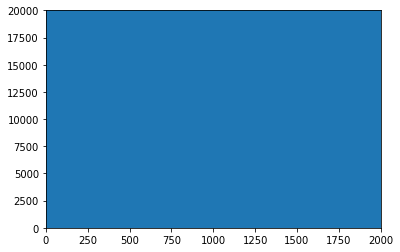

In [7]:
import matplotlib.pyplot as plt

plt.hist(fixed_down[:].ravel(), bins=1024)
plt.xlim([0, 2000])
plt.ylim([0, 20000])
plt.show()

In [8]:
from phathom.registration import coarse

threshold = 180
opt_kwargs = {'niter': 5,
              't0': np.zeros(3),
              'theta0': np.array([0, 0, 0])}

t_down, theta, center_down = coarse.coarse_registration(moving_down, 
                                                        fixed_down, 
                                                        threshold,
                                                        opt_kwargs)

TypeError: unorderable types: Array() > int()

In [6]:
registered_down = coarse.rigid_warp(moving_down, 
                                    t_down, 
                                    theta, 
                                    center_down, 
                                    fixed_down.shape)

plot_both(fixed_down, registered_down, viewer)

In [7]:
true_factors = np.array(fixed_img.shape) / np.array(fixed_down.shape)
t, center = coarse._scale_rigid_params(t_down, 
                                       center_down, 
                                       true_factors)

print('Original', t, center)
print(fixed_img.shape)
print(fixed_down.shape)

# t, center, and theta map fixed coordinates to moving coordinates

Original [312.39652156 358.0636531  -13.5187248 ] [1733.96332053 3756.18215795 2641.98084936]
(3600, 7271, 5530)
(60, 120, 88)


In [12]:
import pickle

transformation_dict = {'t': t,
                       'center': center,
                       'theta': theta}

def save_dict(filename, data):
    with open(filename, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

save_dict('transformation.pkl', transformation_dict)

In [11]:
import pickle

def open_dict(filename):
    with open(filename, 'rb') as handle:
        data = pickle.load(handle)
    return data

transformation_dict = open_dict(project_path+'rigid_transformation.pkl')

t = transformation_dict['t']
center = transformation_dict['center']
theta = transformation_dict['theta']

print('Loaded rigid transformation for original image')
print('Rotation (deg):', theta*180/np.pi)
print('Center (px):', center)
print('Translation (px):', t)

Loaded rigid transformation for original image
Rotation (deg): [-18.74362277  -1.68540621   0.48691592]
Center (px): [1778.21541439 5357.53118993 3449.43518806]
Translation (px): [ 41.97822537 133.16757478 267.64838784]


In [12]:
from phathom.registration import pcloud, coarse
from functools import partial

r = pcloud.rotation_matrix(theta)
transformation = partial(coarse.rigid_transformation, 
                         t=t, 
                         r=r, 
                         center=center)

In [ ]:
from phathom.registration import registration
from numcodecs import Blosc

nb_workers = 48
batch_size = 10000

output_zarr_path = project_path + 'output.zarr'

output_img = zarr.open(output_zarr_path,
                       mode='w',
                       shape=fixed_img.shape,
                       chunks=fixed_img.chunks,
                       dtype=fixed_img.dtype,
                       compressor=Blosc(cname='zstd', 
                                        clevel=1, 
                                        shuffle=Blosc.BITSHUFFLE))
registration.register(moving_img, 
                      fixed_img, 
                      output_img, 
                      transformation, 
                      nb_workers, 
                      batch_size)

In [13]:
registered_img = io.zarr.open(output_zarr_path)

plot_both(fixed_img, registered_img, viewer)

# Warping fixed points

<IPython.core.display.Javascript object>


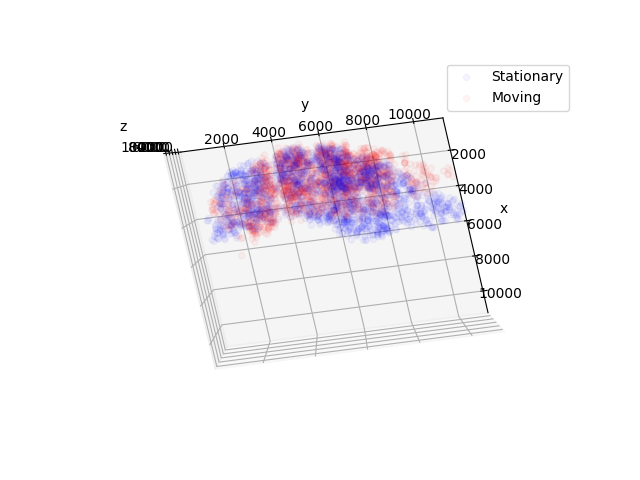

<IPython.core.display.Javascript object>


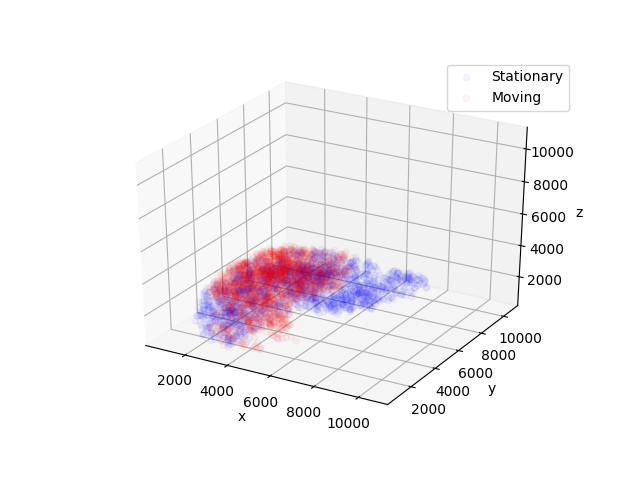

In [14]:
%matplotlib notebook
from phathom import plotting

nb_pts = 2000

transformed_pts = transformation(pts=fixed_pts)

transformed_idx = np.random.choice(np.arange(fixed_pts.shape[0]), nb_pts)
moving_idx = np.random.choice(np.arange(moving_pts.shape[0]), nb_pts)

plotting.plot_pts(fixed_pts[transformed_idx], 
                  moving_pts[moving_idx],
                  alpha=0.04)

plotting.plot_pts(transformed_pts[transformed_idx], 
                  moving_pts[moving_idx], 
                  alpha=0.04)

In [13]:
radius = 200
matching_kwargs = {'max_fdist': 4,
                   'prom_thresh': 0.1}

idx_fixed, idx_moving = pcloud.radius_matching(transformed_pts, 
                                               moving_pts, 
                                               fixed_feat, 
                                               moving_feat, 
                                               radius, 
                                               nb_workers=None, 
                                               batch_size=None, 
                                               matching_kwargs=matching_kwargs)

print(idx_fixed.shape)

(20,)


In [16]:
np.save(project_path + 'idx_fixed.npy', idx_fixed)
np.save(project_path + 'idx_moving.npy', idx_moving)

In [13]:
idx_fixed = np.load('idx_fixed.npy')
idx_moving = np.load('idx_moving.npy')

print(idx_fixed.shape)

(16649,)


<IPython.core.display.Javascript object>


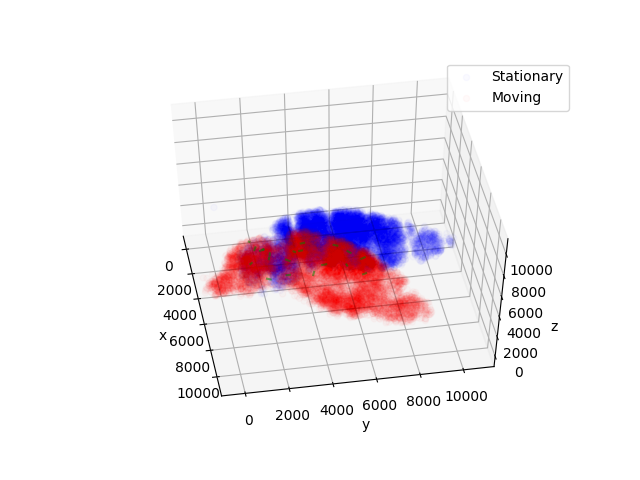

In [14]:
plotting.plot_pts(moving_pts[moving_idx], 
                  transformed_pts[transformed_idx], 
                  alpha=0.02,
                  candid1=moving_pts[idx_moving],
                  candid2=transformed_pts[idx_fixed])

In [7]:
fixed_keypoints_um = fixed_pts[idx_fixed] * np.asarray(voxel_dimensions)
moving_keypoints_um = moving_pts[idx_moving] * np.asarray(voxel_dimensions)

Average coherence: 0.9996335474640778
Found 2 outliers


<IPython.core.display.Javascript object>


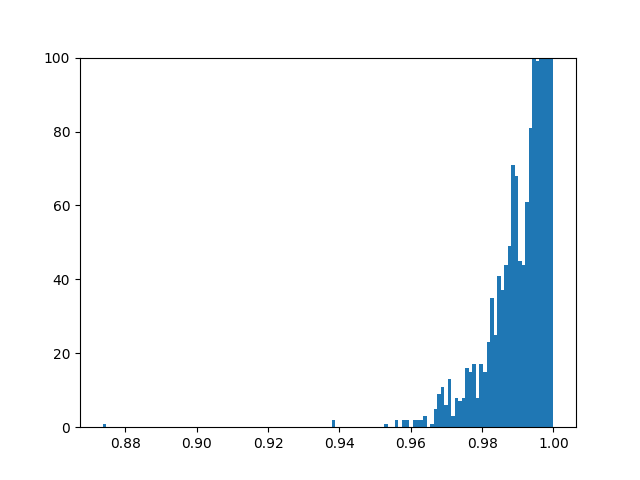

In [9]:
from sklearn.neighbors import NearestNeighbors
from scipy import spatial
import matplotlib.pyplot as plt

n_neighbors = 3
min_similarity = 0.96

nbrs = NearestNeighbors(n_neighbors=n_neighbors+1, algorithm='kd_tree', n_jobs=-1)
nbrs.fit(fixed_keypoints_um)
distances, indices = nbrs.kneighbors(fixed_keypoints_um)

cosine_similarity = np.zeros((idx_fixed.shape[0], n_neighbors))
for i, idxs in enumerate(indices):
    displacement = moving_keypoints_um[i] - fixed_keypoints_um[i]
    
    neighbor_idxs = idxs[1:]
    fixed_neighbors = fixed_keypoints_um[neighbor_idxs]
    moving_neighbors = moving_keypoints_um[neighbor_idxs]
    displacement_neighbors = moving_neighbors - fixed_neighbors
    
    for j, d in enumerate(displacement_neighbors):
        cosine_similarity[i, j] = 1-spatial.distance.cosine(displacement, d)

coherence = cosine_similarity.mean(axis=-1)

inlier_idx = np.where(coherence > min_similarity)
outlier_idx = np.where(coherence <= min_similarity)

print('Average coherence: {}'.format(coherence.mean()))
print('Found {} outliers'.format(len(coherence)-len(inlier_idx[0])))
        
plt.hist(cosine_similarity.ravel(), bins=128)
plt.ylim([0, 100])
plt.show()

<IPython.core.display.Javascript object>


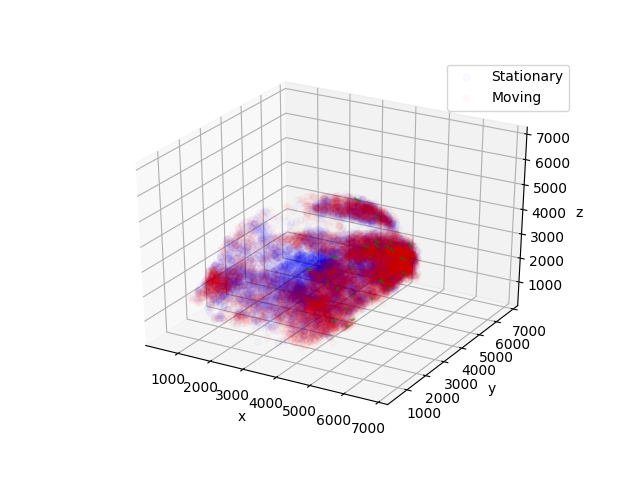

In [66]:
plotting.plot_pts(moving_pts[moving_idx], 
                  transformed_pts[transformed_idx], 
                  alpha=0.02,
                  candid1=moving_pts[idx_moving[outlier_idx]],
                  candid2=transformed_pts[idx_fixed[outlier_idx]])

In [152]:
resid_thresh = None

ransac, ransac_inliers = pcloud.estimate_affine(transformed_pts[idx_fixed[inlier_idx]],
                                            moving_pts[idx_moving[inlier_idx]],
                                            min_samples=24,
                                            residual_threshold=resid_thresh)
print(ransac_inliers.shape)
moving_inliers = moving_pts[idx_moving[ransac_inliers]]
transformed_inliers = transformed_pts[idx_fixed[ransac_inliers]]

(16649,)


<IPython.core.display.Javascript object>


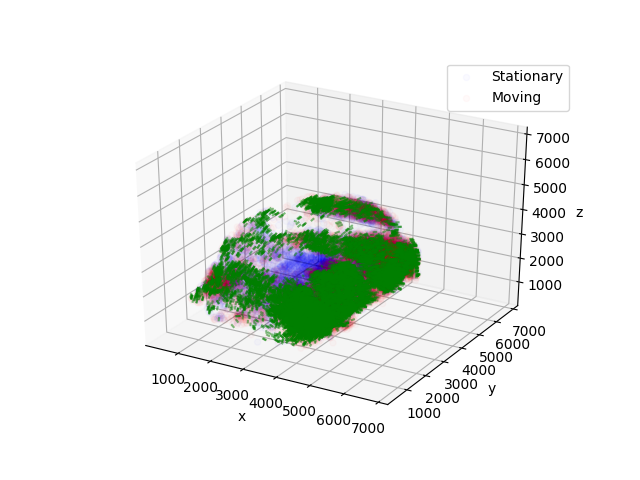

In [69]:
plotting.plot_pts(moving_pts[moving_idx], 
                  transformed_pts[transformed_idx], 
                  alpha=0.02,
                  candid1=moving_inliers,
                  candid2=transformed_inliers)

In [153]:
residuals = np.linalg.norm(moving_inliers - transformed_inliers, axis=-1)
ave_resid = np.mean(residuals)
print(ave_resid)

54.81332611909927


In [10]:
fixed_keypts = fixed_pts[idx_fixed[inlier_idx]]
moving_keypts = moving_pts[idx_moving[inlier_idx]]

print(fixed_keypts)
print(moving_keypts)

[[ 231 1015 2196]
 [ 254 2163 1474]
 [ 283  952 3768]
 ...
 [3395 4367 2158]
 [3390 4303 2083]
 [3486 4756 2304]]
[[ 566 1504 1732]
 [ 587 2773 1235]
 [ 615 1199 3271]
 ...
 [3732 4840 2247]
 [3726 4788 2162]
 [3823 5202 2451]]


# Non-rigid registration

<IPython.core.display.Javascript object>


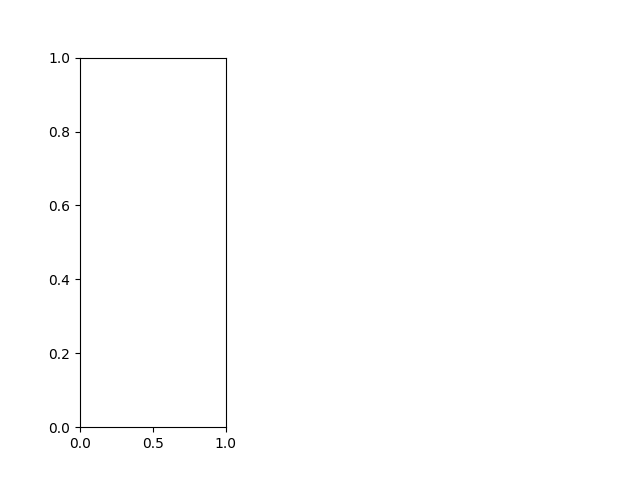

NameError: name 'fixed_keypts_um' is not defined

In [18]:
import matplotlib.pyplot as plt
alpha = 0.005
plt.subplot(1,3,1)
plt.scatter(fixed_keypts_um[:, 0], moving_keypts_um[:, 0], alpha=alpha)
plt.subplot(1,3,2)
plt.scatter(fixed_keypts_um[:, 1], moving_keypts_um[:, 1], alpha=alpha)
plt.subplot(1,3,3)
plt.scatter(fixed_keypts_um[:, 2], moving_keypts_um[:, 2], alpha=alpha)
plt.show()

<IPython.core.display.Javascript object>


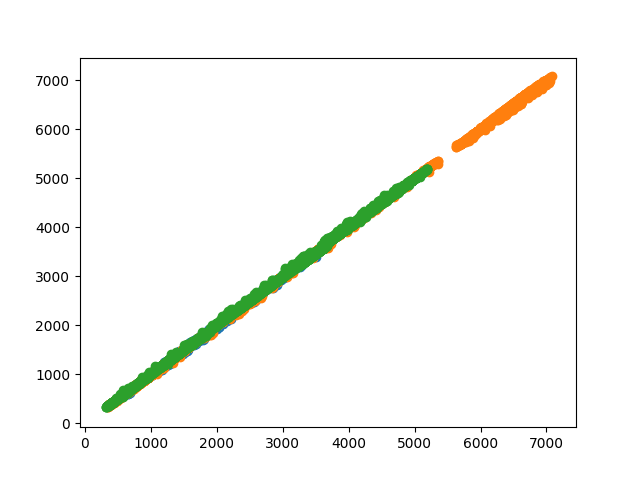

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

degree = 2

def fit_polynomial_transform(fixed_keypts, moving_keypts, degree):
    fixed_poly = PolynomialFeatures(degree=degree).fit_transform(fixed_keypts)
    model_z = LinearRegression(fit_intercept=False).fit(fixed_poly, moving_keypts[:, 0])
    model_y = LinearRegression(fit_intercept=False).fit(fixed_poly, moving_keypts[:, 1])
    model_x = LinearRegression(fit_intercept=False).fit(fixed_poly, moving_keypts[:, 2])
    
    return model_z, model_y, model_x

def polynomial_transform(pts, degree, model_z, model_y, model_x):
    poly = PolynomialFeatures(degree=degree).fit_transform(pts)
    transformed_keypts = np.empty_like(pts)
    transformed_keypts[:, 0] = model_z.predict(poly)
    transformed_keypts[:, 1] = model_y.predict(poly)
    transformed_keypts[:, 2] = model_x.predict(poly)
    return transformed_keypts

model_z, model_y, model_x = fit_polynomial_transform(fixed_keypts, moving_keypts, degree)
nonrigid_transformation = partial(polynomial_transform, 
                                  degree=degree,
                                  model_z=model_z, 
                                  model_y=model_y, 
                                  model_x=model_x)
transformed_keypts = nonrigid_transformation(pts=fixed_keypts)

plt.scatter(transformed_keypts[:, 0], moving_keypts[:, 0])
plt.scatter(transformed_keypts[:, 1], moving_keypts[:, 1])
plt.scatter(transformed_keypts[:, 2], moving_keypts[:, 2])
plt.show()

In [12]:
nonrigid_residuals = np.linalg.norm(transformed_keypts-moving_keypts, axis=-1)
ave_resid_nonrigid = np.mean(nonrigid_residuals)
print(ave_resid_nonrigid)

9.826318541639464


In [182]:
plt.hist(residuals, bins=50)
plt.show()

<IPython.core.display.Javascript object>


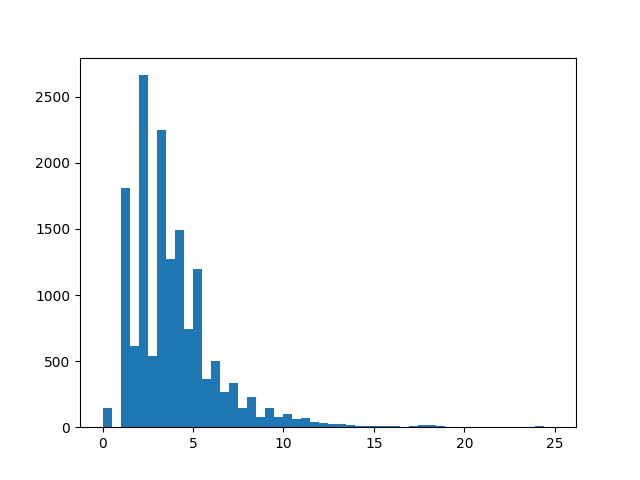

In [183]:
plt.hist(nonrigid_residuals, bins=50)
plt.show()

3.9612147398137934


<IPython.core.display.Javascript object>


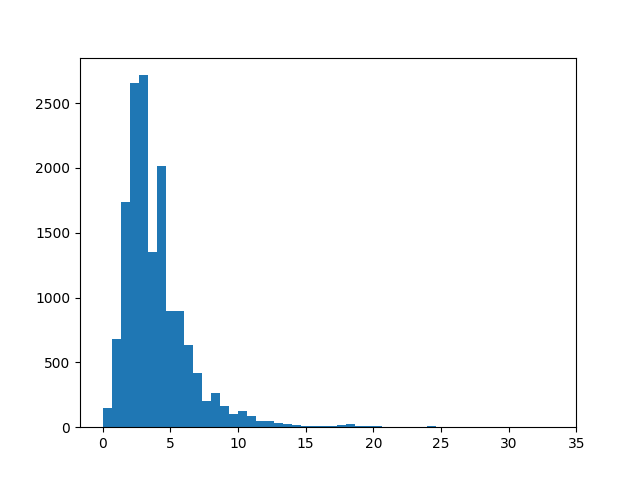

In [13]:
max_distance = 25

distance_inliers = np.where(nonrigid_residuals <= max_distance)

fixed_keypts = fixed_keypts[distance_inliers]
moving_keypts = moving_keypts[distance_inliers]

model_z, model_y, model_x = fit_polynomial_transform(fixed_keypts, moving_keypts, degree)
nonrigid_transformation = partial(polynomial_transform, 
                                  degree=degree,
                                  model_z=model_z, 
                                  model_y=model_y, 
                                  model_x=model_x)
transformed_keypts = nonrigid_transformation(pts=fixed_keypts)


nonrigid_residuals = np.linalg.norm(transformed_keypts-moving_keypts, axis=-1)
ave_resid_nonrigid = np.mean(nonrigid_residuals)
print(ave_resid_nonrigid)

plt.hist(nonrigid_residuals, bins=50)
plt.show()


In [14]:
from phathom.registration import registration
from numcodecs import Blosc

nb_workers = 4
batch_size = 10000

output_zarr_path = project_path + 'nonrigid.zarr'

nonrigid_img = zarr.open(output_zarr_path,
                         mode='w',
                         shape=fixed_img.shape,
                         chunks=fixed_img.chunks,
                         dtype=fixed_img.dtype,
                         compressor=Blosc(cname='zstd', 
                                          clevel=1, 
                                          shuffle=Blosc.BITSHUFFLE))

registration.register(moving_img, 
                      fixed_img, 
                      nonrigid_img, 
                      nonrigid_transformation, 
                      nb_workers, 
                      batch_size)

In [7]:
nonrigid_img = io.zarr.open(output_zarr_path)

plot_both(fixed_img, nonrigid_img, viewer)

# Image fusion

https://academic.oup.com/bioinformatics/article/28/2/238/196424

In [ ]:
import phathom.io as io
import phathom.io.conversion as conversion

output_zarr_path = 'nonrigid.zarr'
output_dir = 'nonrigid'
nb_workers = 20
compress = 1

io.conversion.zarr_to_tifs(output_zarr_path, output_dir, nb_workers, compress)

In [20]:
registered_img = zarr.open('nonrigid.zarr', mode='r')
fixed_img = zarr.open('fixed.zarr', mode='r')

plot_both(fixed_img, registered_img, viewer)

In [21]:
registered_middle = registered_img[1200]
fixed_middle = fixed_img[1200]

import tifffile

tifffile.imsave('reg.tif', registered_middle, compress=1)
tifffile.imsave('fix.tif', fixed_middle, compress=1)